In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=0f37a5267ee4fce7c8ffef65769c3e4fcf07c1472226c8dfb377121661e94577
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import os
import json
import torch
import itertools
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel, ViTModel, ViTFeatureExtractor, MarianMTModel, MarianTokenizer
from langdetect import detect
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image


In [3]:
# Step 1: Mount Google Drive to access the dataset.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Paths to data
image_folder = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/Flicker8k_Dataset'
caption_file = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/BAN-Cap_captiondata.json'

# Load captions from JSON file
with open(caption_file, 'r', encoding='utf-8') as f:
    captions_data = json.load(f)

# Convert captions to DataFrame
captions_list = []
for entry in captions_data:
    if 'caption_id' in entry and 'english_caption' in entry:
        filename = entry['caption_id'].split('#')[0]
        caption = entry['english_caption']
        captions_list.append({"filename": filename, "caption": caption})

df = pd.DataFrame(captions_list)
print(f"Total captions loaded: {len(df)}")

# Filter image files
image_filenames = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

# Match images with captions
captions = []
for filename in image_filenames:
    matching_captions = df[df['filename'] == filename]['caption'].tolist()
    if len(matching_captions) >= 2:
        captions.append(matching_captions[0])

assert len(captions) > 0, "No captions found!"
assert len(image_filenames) == len(captions), "Mismatch between images and captions!"
print(f"Total images matched with captions: {len(image_filenames)}")


Total captions loaded: 40455
Total images matched with captions: 8091


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, ViTModel, ViTFeatureExtractor
from langdetect import detect
from transformers import MarianMTModel, MarianTokenizer

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# Vision Transformer Model
vit_model_name = 'google/vit-base-patch16-224'
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)
vit_model = ViTModel.from_pretrained(vit_model_name).to(device)
image_embedding_size = vit_model.config.hidden_size


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Bangla BERT Model
bangla_bert_name = 'bert-base-multilingual-cased'
text_tokenizer = AutoTokenizer.from_pretrained(bangla_bert_name)
text_model = AutoModel.from_pretrained(bangla_bert_name).to(device)
text_embedding_size = text_model.config.hidden_size


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [8]:
# Updated Projection class with increased dropout
class Projection(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.4):
        super(Projection, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(output_size, output_size)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x


#. Define the Translator Class

In [9]:
# Translator Class
class Translator:
    def __init__(self):
        self.model_name = "Helsinki-NLP/opus-mt-mul-en"
        self.tokenizer = MarianTokenizer.from_pretrained(self.model_name)
        self.model = MarianMTModel.from_pretrained(self.model_name)

    def translate(self, text):
        if detect(text) == 'en':  # Skip translation if already in English
            return text
        inputs = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        outputs = self.model.generate(**inputs)
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)


In [10]:
# Multilingual CLIP Model
class MultilingualCLIPModel(nn.Module):
    def __init__(self, image_model, text_model, image_projector, text_projector, translator, tokenizer_name):
        super(MultilingualCLIPModel, self).__init__()
        self.image_model = image_model
        self.text_model = text_model
        self.image_projector = image_projector
        self.text_projector = text_projector
        self.translator = translator
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)  # Initialize tokenizer here

    def forward(self, images, captions):
        captions = [self.translator.translate(caption) for caption in captions]
        text_inputs = self.tokenizer(captions, return_tensors='pt', padding="max_length", max_length=32, truncation=True).to(device)
        text_embeddings = self.text_projector(self.text_model(**text_inputs).last_hidden_state[:, 0, :])
        image_embeddings = self.image_projector(self.image_model(pixel_values=images)["last_hidden_state"][:, 0, :])
        return image_embeddings, text_embeddings


# Instantiate Translator and Combined Model

In [18]:
# Define shared embedding size (shared between image and text)
shared_embedding_size = 512

# Ensure ViT and Bangla-BERT are defined earlier in the script
image_embedding_size = vit_model.config.hidden_size
text_embedding_size = text_model.config.hidden_size





In [19]:
image_projector = Projection(image_embedding_size, shared_embedding_size, dropout_rate=0.5).to(device)
text_projector = Projection(text_embedding_size, shared_embedding_size, dropout_rate=0.5).to(device)


In [20]:


# Translator
translator = Translator()

# Instantiate the Combined Model
multilingual_clip_model = MultilingualCLIPModel(
    image_model=vit_model,
    text_model=text_model,
    image_projector=image_projector,  # Use the initialized projector
    text_projector=text_projector,    # Use the initialized projector
    translator=translator,
    tokenizer_name=bangla_bert_name
).to(device)


In [21]:
import os
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_folder, image_size=224):
        self.image_filenames = image_filenames
        self.captions = captions
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        # Build the full path to the image
        image_path = os.path.join(self.image_folder, self.image_filenames[index])

        # Open and preprocess the image
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found: {image_path}")

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Get the corresponding caption
        caption = self.captions[index]

        return image, caption

# Instantiate Dataset
image_folder = '/content/drive/MyDrive/Bangla Image dataset with caption/Flickr8k_Dataset/Flicker8k_Dataset'

# Collect image filenames and captions from the dataset
image_filenames = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]
captions = df[df['filename'].isin(image_filenames)]['caption'].tolist()

if len(image_filenames) != len(captions):
    print(f"Warning: Mismatch between images and captions! ({len(image_filenames)} images, {len(captions)} captions)")

dataset = ImageTextDataset(image_filenames, captions, image_folder)
print(f"Dataset size: {len(dataset)}")

# DataLoader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Dataset size: 8091


In [22]:
# Match images with their corresponding captions
matched_captions = []
matched_filenames = []

for filename in image_filenames:
    # Retrieve all captions for the current image
    matching_captions = df[df['filename'] == filename]['caption'].tolist()

    # If captions are found, use the first caption or randomly select one
    if matching_captions:
        matched_captions.append(matching_captions[0])  # Use the first caption
        matched_filenames.append(filename)

# Ensure we only process matched pairs
assert len(matched_filenames) == len(matched_captions), "Mismatch after matching!"
print(f"Matched images and captions: {len(matched_filenames)}")

# Create the Dataset using matched data
dataset = ImageTextDataset(matched_filenames, matched_captions, image_folder)
print(f"Dataset size: {len(dataset)}")

# DataLoader
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Matched images and captions: 8091
Dataset size: 8091


#Define Training Loop and Loss Function

In [23]:
# Updated contrastive loss with label smoothing
def contrastive_loss(image_embeddings, text_embeddings, temperature=0.1, label_smoothing=0.1):
    # Normalize embeddings
    image_embeddings = F.normalize(image_embeddings, p=2, dim=1)
    text_embeddings = F.normalize(text_embeddings, p=2, dim=1)

    # Compute similarity scores
    logits = torch.mm(image_embeddings, text_embeddings.t()) / temperature

    # Labels are indices of correct matches
    labels = torch.arange(logits.size(0)).to(device)

    # Apply label smoothing
    smooth_labels = (1.0 - label_smoothing) * torch.eye(logits.size(0)).to(device) + \
                    (label_smoothing / (logits.size(0) - 1)) * (1 - torch.eye(logits.size(0))).to(device)

    # Loss calculation with smoothing
    loss = -torch.mean(torch.sum(F.log_softmax(logits, dim=1) * smooth_labels, dim=1))
    return loss

In [24]:
optimizer = torch.optim.Adam(multilingual_clip_model.parameters(), lr=1e-6)


# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


Epoch 1/10 - Validation: 100%|██████████| 2023/2023 [07:25<00:00,  4.54it/s]


Epoch 1/10, Train Loss: 1.4407, Val Loss: 1.3892


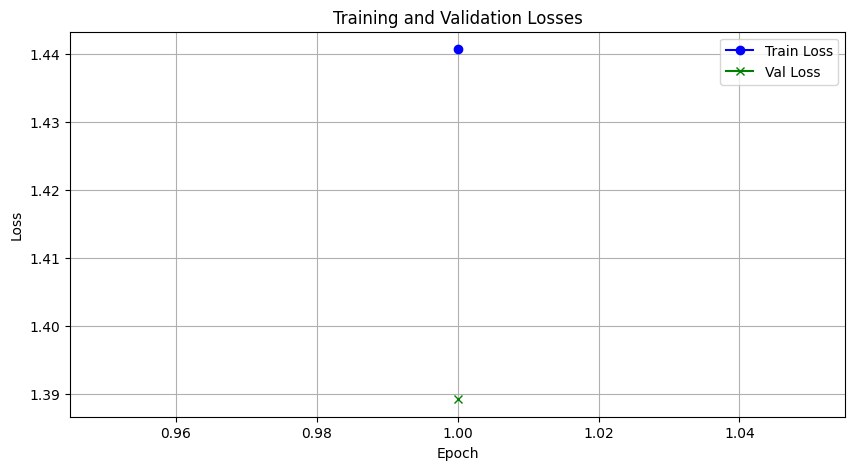

Epoch 2/10 - Validation: 100%|██████████| 2023/2023 [07:45<00:00,  4.34it/s]


Epoch 2/10, Train Loss: 1.4388, Val Loss: 1.3879


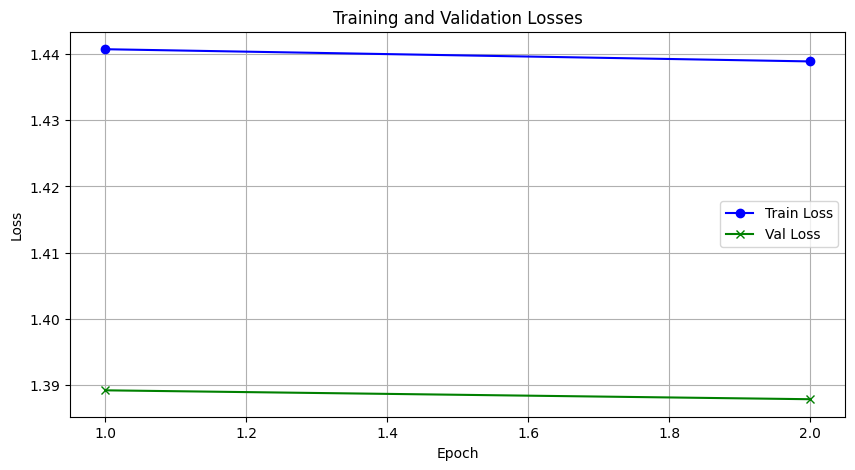

Epoch 3/10 - Training:  29%|██▉       | 587/2023 [04:15<11:59,  2.00it/s, Train Loss=0.419]

In [ ]:
# Training Loop with Gradient Clipping and Scheduler
epochs = 10
train_losses = []
val_losses = []

for epoch in range(epochs):
    multilingual_clip_model.train()
    epoch_loss = 0

    train_progress = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training", colour="blue")
    for batch in train_progress:
        images, captions = batch

        # Revert images to [0, 1] range
        unnormalized_images = torch.clamp((images * 0.5) + 0.5, 0, 1)

        # Preprocess images using ViTFeatureExtractor
        pixel_values = torch.stack([
            vit_feature_extractor(
                unnormalized_image.permute(1, 2, 0).numpy(),
                return_tensors="pt"
            )['pixel_values'].squeeze(0)
            for unnormalized_image in unnormalized_images
        ]).to(device)

        # Forward pass
        image_embeddings, text_embeddings = multilingual_clip_model(pixel_values, captions)

        # Compute loss
        loss = contrastive_loss(image_embeddings, text_embeddings)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(multilingual_clip_model.parameters(), max_norm=1.0)

        optimizer.step()

        epoch_loss += loss.item()
        train_progress.set_postfix({"Train Loss": epoch_loss / len(train_progress)})

    avg_train_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    multilingual_clip_model.eval()
    val_loss = 0

    val_progress = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Validation", colour="green")
    with torch.no_grad():
        for batch in val_progress:
            images, captions = batch

            unnormalized_images = torch.clamp((images * 0.5) + 0.5, 0, 1)
            pixel_values = torch.stack([
                vit_feature_extractor(
                    unnormalized_image.permute(1, 2, 0).numpy(),
                    return_tensors="pt"
                )['pixel_values'].squeeze(0)
                for unnormalized_image in unnormalized_images
            ]).to(device)

            image_embeddings, text_embeddings = multilingual_clip_model(pixel_values, captions)
            loss = contrastive_loss(image_embeddings, text_embeddings)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(dataloader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Step the scheduler
    scheduler.step(avg_val_loss)

    # Plot losses after each epoch
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color="blue", marker="o")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss", color="green", marker="x")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Losses")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# Save the trained model
torch.save(multilingual_clip_model.state_dict(), "multilingual_clip_model22222.pth")
print("Model saved successfully!")


In [ ]:
# Define the Google Drive path for saving the model
save_path = "/content/drive/MyDrive/Bangla Image dataset with caption/best_text_projector_multilingual22222.pt"

# Save the trained model's state dictionary to the specified path
torch.save(multilingual_clip_model.state_dict(), save_path)

print(f"Model saved successfully at: {save_path}")


#Interface

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to create image embeddings
def create_image_embeddings(images, vit_model, image_projector, device):
    with torch.no_grad():
        # Rescale pixel values from [-1, 1] to [0, 1]
        images = torch.clamp((images + 1) / 2, 0, 1)  # Ensures values are in the [0, 1] range
        features = vit_feature_extractor(images=images.permute(0, 2, 3, 1).cpu().numpy(), return_tensors="pt").to(device)
        image_embeddings = vit_model(**features).last_hidden_state[:, 0, :]
        image_projection = image_projector(image_embeddings)
    return image_projection

# Precompute and store image embeddings for all training images
def precompute_image_embeddings(train_dataset, vit_model, image_projector, device):
    image_embeddings_list = []
    for index in tqdm(range(len(train_dataset)), desc="Processing Training Images"):
        images = train_dataset[index][0].unsqueeze(0).to(device)  # Add batch dimension and move to device
        image_projection = create_image_embeddings(images, vit_model, image_projector, device)
        image_embeddings_list.append(image_projection[0].cpu())  # Store on CPU to save GPU memory
    return image_embeddings_list

# Function for image retrieval based on text query
def image_retrieval_function(input_query, translator, text_tokenizer, text_model, text_projector, train_dataset, image_embeddings_list, device, n=5, display=False):
    with torch.no_grad():
        # Translate query if not in English
        translated_query = translator.translate(input_query)

        # Process text query and create embeddings
        inputs = text_tokenizer(translated_query, return_tensors='pt', padding="max_length", max_length=32, truncation=True).to(device)
        text_embeddings = text_model(**inputs).last_hidden_state[:, 0, :]
        text_projection = text_projector(text_embeddings)

    # Compute similarity scores between the query and all stored image embeddings
    similarity_scores = []
    for image_projection in image_embeddings_list:
        image_projection = image_projection.to(device)
        similarity = F.cosine_similarity(text_projection, image_projection.unsqueeze(0))
        similarity_scores.append(similarity.item())

    # Get indices of the top n most similar images
    top_indices = np.argsort(similarity_scores)[-n:][::-1]

    if display:
        for index in top_indices:
            image_tensor = train_dataset[index][0]  # Retrieve original image from dataset
            plt.imshow(torch.moveaxis(image_tensor, 0, 2))  # Convert CHW to HWC
            plt.title(f"Similarity Score: {similarity_scores[index]:.4f}")
            plt.axis('off')
            plt.show()
    else:
        return top_indices

# Example Usage:
# Precompute image embeddings
image_embeddings_list_train = precompute_image_embeddings(train_dataset, vit_model, image_projector, device)

# Perform image retrieval
query = "A beautiful sunset over the mountains."
retrieved_indices = image_retrieval_function(
    query,
    translator,
    text_tokenizer,
    text_model,
    text_projector,
    train_dataset,
    image_embeddings_list_train,
    device,
    n=5,
    display=True
)
